In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [3]:
df = pd.read_csv(r"C:\Users\user\OneDrive - University of Saint Joseph\Desktop\archive\Training_set.csv")
image_dir = r"C:\Users\user\OneDrive - University of Saint Joseph\Desktop\archive\train"
print(f"Total images: {len(df)}")
print(df.head())

Total images: 6499
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART


In [4]:
len(df)

6499

C:\Users\user\AppData\Local\Temp\ipykernel_8912\3865910680.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


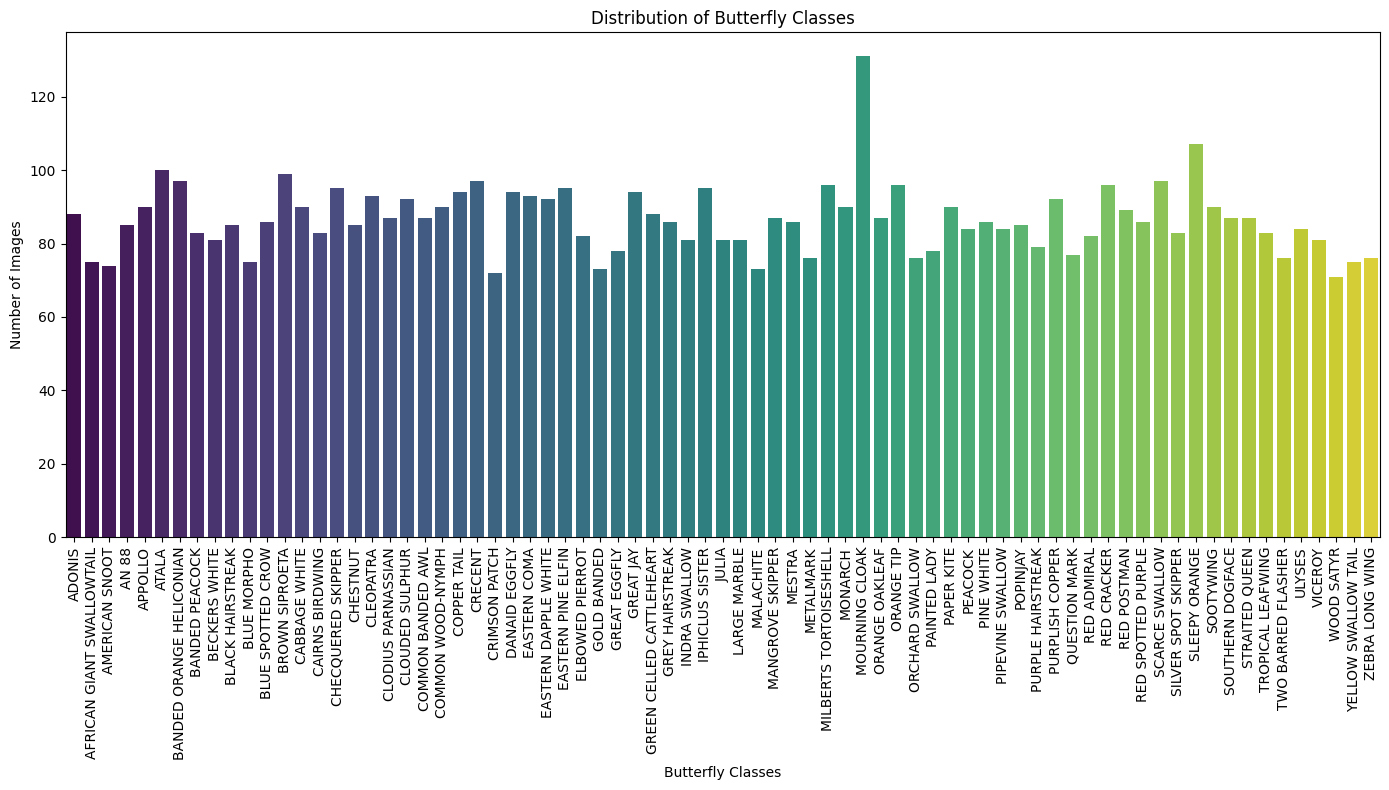

In [5]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

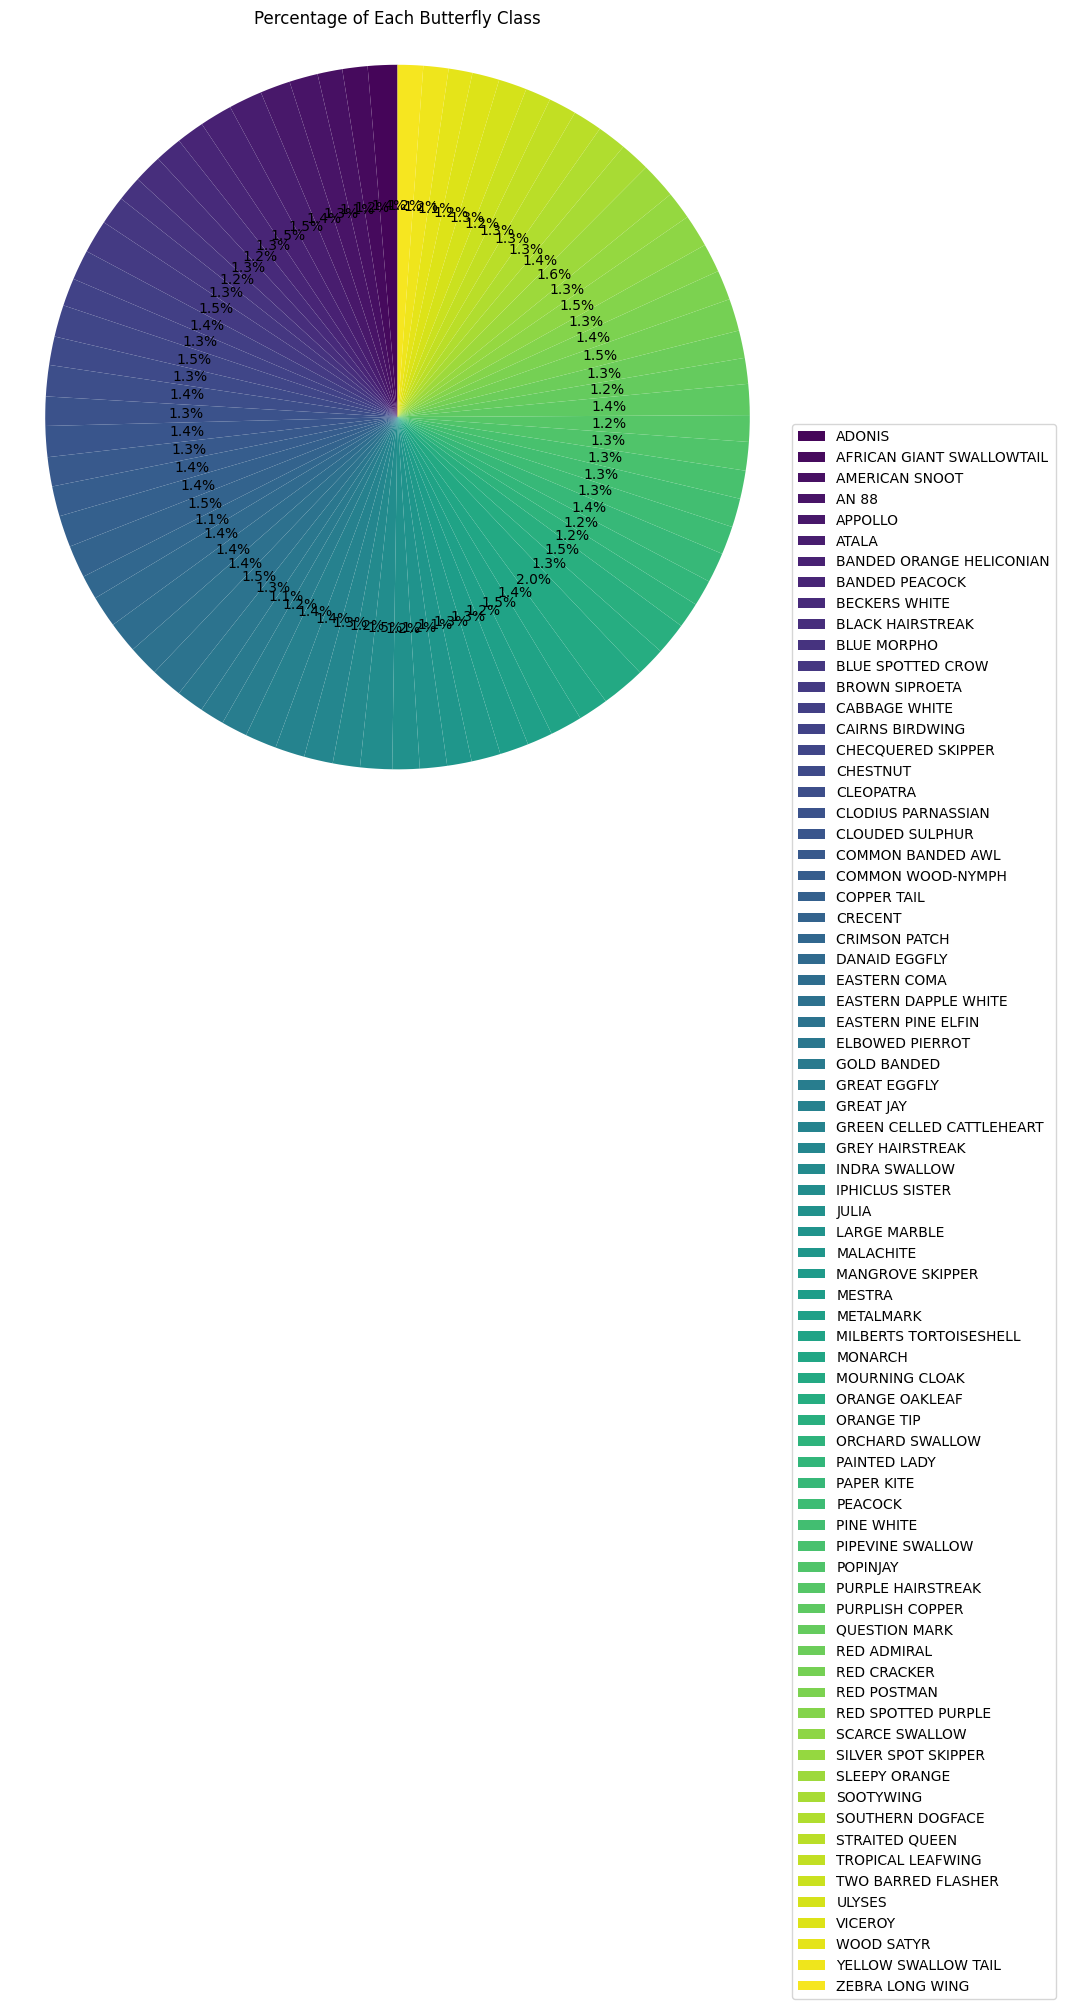

In [6]:
colors = sns.color_palette("viridis", len(class_counts))
class_counts = df['label'].value_counts().sort_index()


plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Each Butterfly Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(class_counts.index, loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

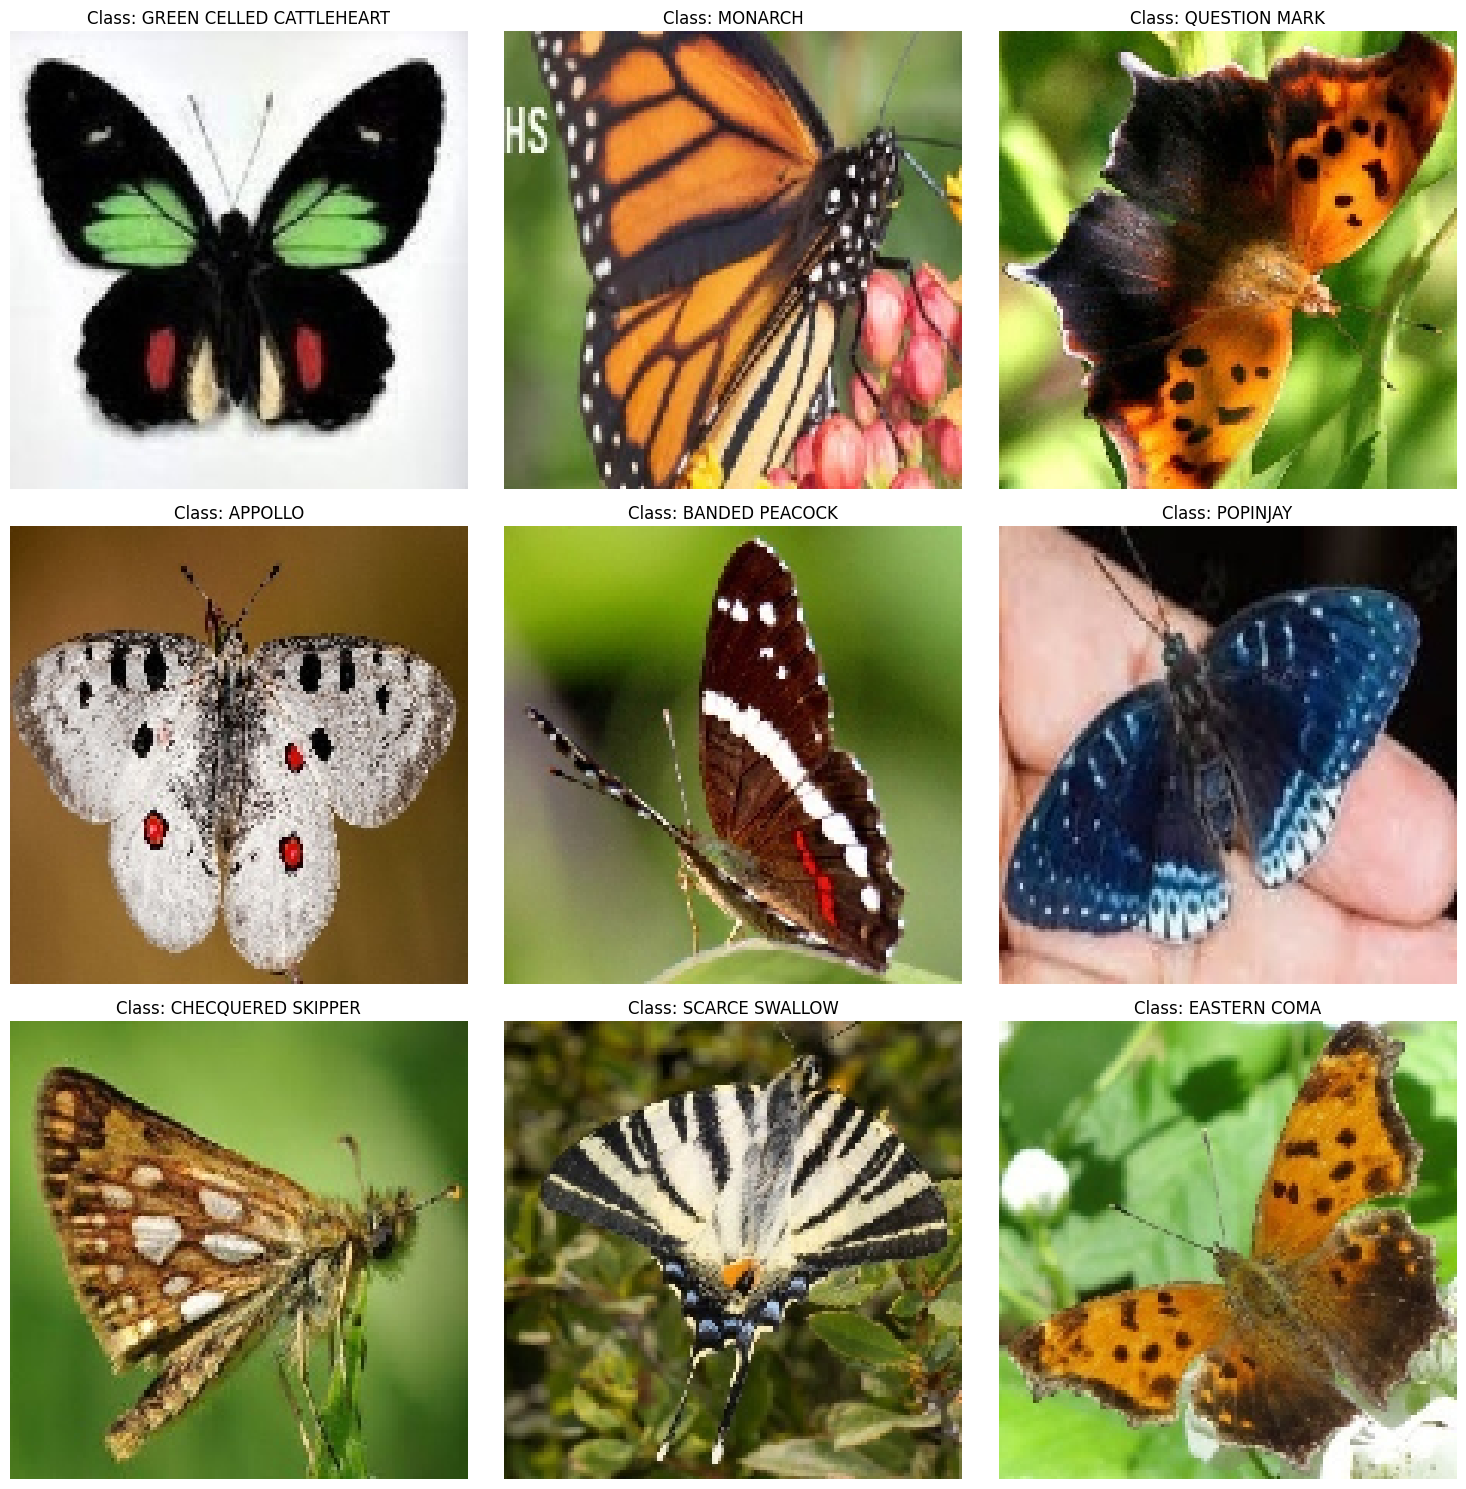

In [7]:
image_dir = r"C:\Users\user\OneDrive - University of Saint Joseph\Desktop\archive\train"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Nombre de caractéristiques chargées : (6499, 30000)


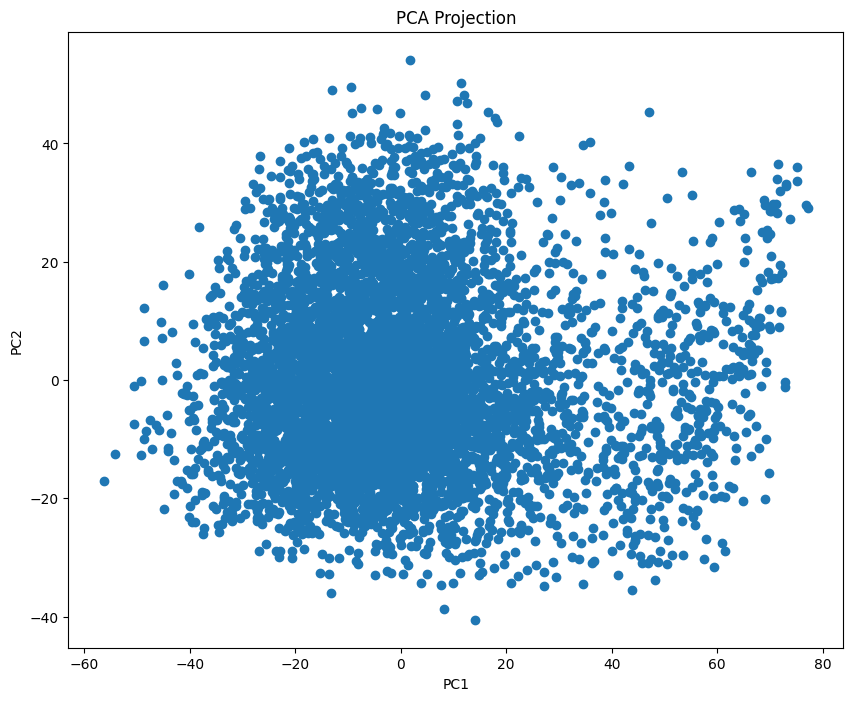

In [8]:


def load_images_from_folder(folder_path, target_size=(100, 100)):
    features = []
    for image_file in os.listdir(folder_path):
        if image_file.lower().endswith((".png", ".jpg", ".jpeg")):  # Accepter certains formats
            image_path = os.path.join(folder_path, image_file)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
            features.append(img_array.flatten())  # Aplatir l'image en un vecteur
    return np.array(features)

# Chemin vers le dossier contenant les images
folder_path = r"C:\Users\user\OneDrive - University of Saint Joseph\Desktop\archive\train"

# Chargement des images et préparation des caractéristiques
features = load_images_from_folder(folder_path)
print("Nombre de caractéristiques chargées :", features.shape)

# Assurer que features n'est pas vide
if features.size > 0:
    # Normalisation des caractéristiques
    features = features / 255.0

    # Application de PCA
    pca = PCA(n_components=2)
    features_reduced = pca.fit_transform(features)

    # Visualisation de PCA
    plt.figure(figsize=(10, 8))
    plt.scatter(features_reduced[:, 0], features_reduced[:, 1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Projection')
    plt.show()
else:
    print("Aucune image n'a été chargée, vérifiez le chemin et les formats des fichiers.")


In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = r"C:\Users\user\OneDrive - University of Saint Joseph\Desktop\archive\train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(75, activation='softmax') #to match the nb of classes 
])

model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 75)                  │          38,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 134s 811ms/step - accuracy: 0.0421 - loss: 4.1475 - val_accuracy: 0.1844 - val_loss: 3.1735
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.0625 - loss: 3.4238 - val_accuracy: 0.1961 - val_loss: 3.1975
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 130s 804ms/step - accuracy: 0.1964 - loss: 3.1087 - val_accuracy: 0.3508 - val_loss: 2.3784
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.3750 - loss: 2.4773 - val_accuracy: 0.3562 - val_loss: 2.4008
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 128s 788ms/step - accuracy: 0.3273 - loss: 2.4891 - val_accuracy: 0.3898 - val_loss: 2.2295
Epoch 6/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3750 - loss: 1.8810 - val_accuracy: 0.4102 - val_loss: 2.1189
Epoch 7/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 127s 784ms/step - accuracy: 0.4157 - loss: 2.1205 - val_accuracy: 0.4805 - val_loss: 1.8867
Epoch 8/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2812 - loss: 2.3

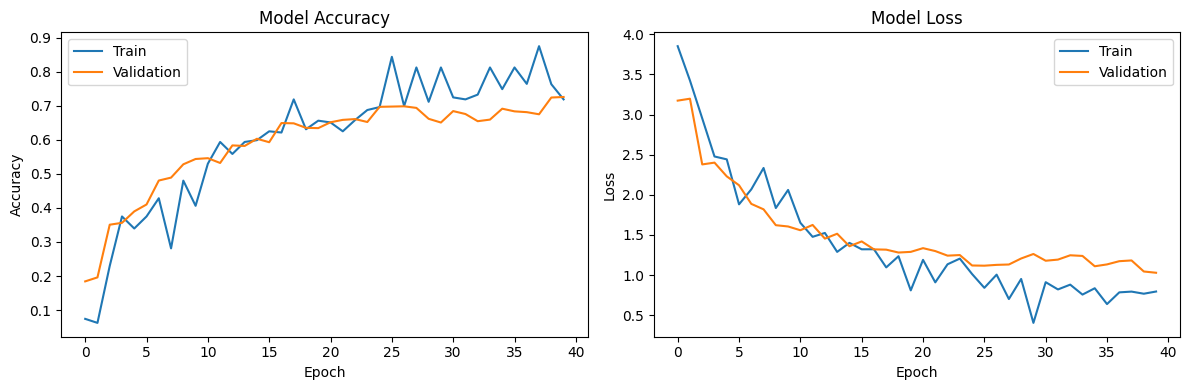

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step

Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       0.87      0.87      0.87        15
AFRICAN GIANT SWALLOWTAIL       0.94      0.84      0.89        19
           AMERICAN SNOOT       0.67      0.67      0.67        12
                    AN 88       1.00      1.00      1.00        10
                  APPOLLO       0.86      0.95      0.90        20
                    ATALA       0.77      1.00      0.87        17
 BANDED ORANGE HELICONIAN       0.87      0.68      0.76        19
           BANDED PEACOCK       0.75      0.80      0.77        15
            BECKERS WHITE       0.55      0.33      0.41        18
         BLACK HAIRSTREAK       0.82      0.78      0.80        18
              BLUE MORPHO       0.82      0.56      0.67        16
        BLUE SPOTTED CROW       0.69      0.75      0.72        12
           BROWN SIPROETA       0.85      0.85      0.85       

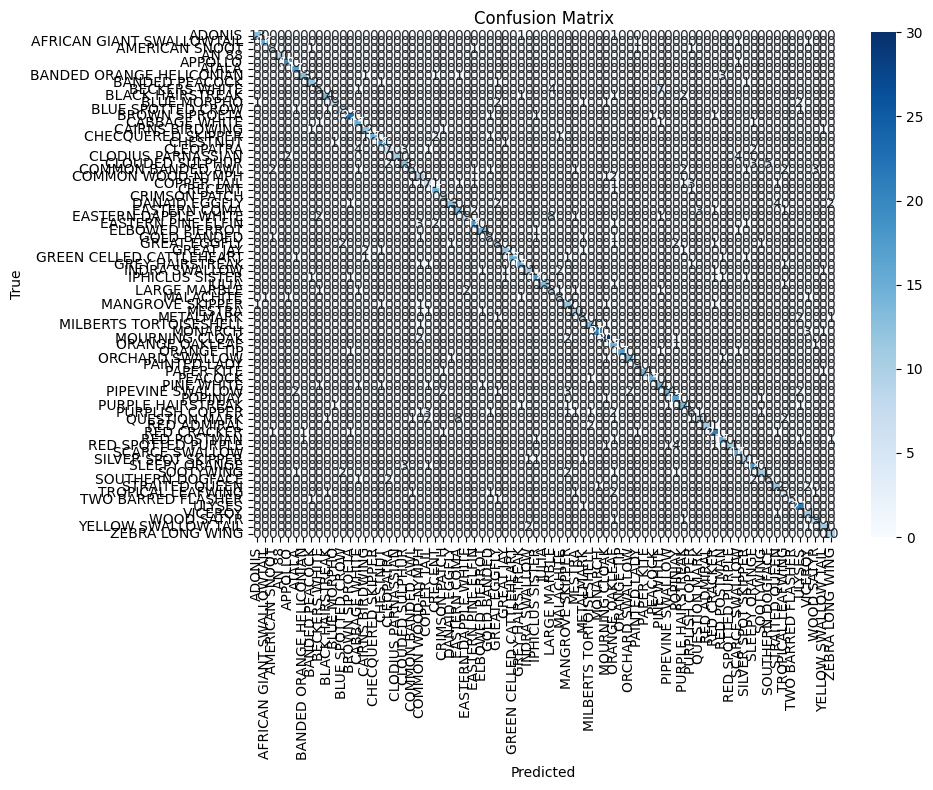

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

val_steps = len(val_generator)

predictions = model_CNN.predict(val_generator, steps=val_steps)

y_pred = np.argmax(predictions, axis=1)

y_true = val_generator.classes           

unique_classes = np.unique(np.concatenate((y_true, y_pred)))
class_names = {v: k for k, v in val_generator.class_indices.items()}
# Filter the class_names to include only those that are present
filtered_class_names = [class_names.get(cls, "Unknown Class") for cls in unique_classes]

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_classes, target_names=filtered_class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import classification_report, precision_score, recall_score
import numpy as np

# Determine the number of batches in the validation generator
val_steps = len(val_generator)

# Predict class probabilities on the entire validation set
pred_probs = model_CNN.predict(val_generator, steps=val_steps)

# Convert predicted probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)

# True labels from the generator (make sure val_generator was created with shuffle=False)
true_labels = val_generator.classes

# Compute precision and recall (macro averaged)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')

print("Precision (macro):", precision)
print("Recall (macro):", recall)

# Optional: Print a full classification report
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    balanced_accuracy_score, 
    cohen_kappa_score, 
    matthews_corrcoef, 
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy:", accuracy)

# F1 Score (macro averaged)
f1 = f1_score(true_labels, pred_labels, average='macro')
print("F1 Score (macro):", f1)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
print("Balanced Accuracy:", balanced_acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step
Precision (macro): 0.7400014290641967
Recall (macro): 0.7348976878343684
Accuracy: 0.7276923076923076
F1 Score (macro): 0.7246447529395806
Balanced Accuracy: 0.7348976878343684


In [18]:
# Import necessary libraries
import numpy as np

# Make predictions
val_images, val_labels = next(val_generator)  # This fetches one batch of validation data
predictions = model_CNN.predict(val_images)
pred_labels = np.argmax(predictions, axis=1)  # Convert softmax output to class indices

# Retrieve true labels from val_labels which are one-hot encoded
true_labels = np.argmax(val_labels, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


In [19]:
# Assuming class indices can be retrieved like this, which maps class labels to their index
class_names = list(val_generator.class_indices.keys())  # Ensure this matches the labels in 'label'


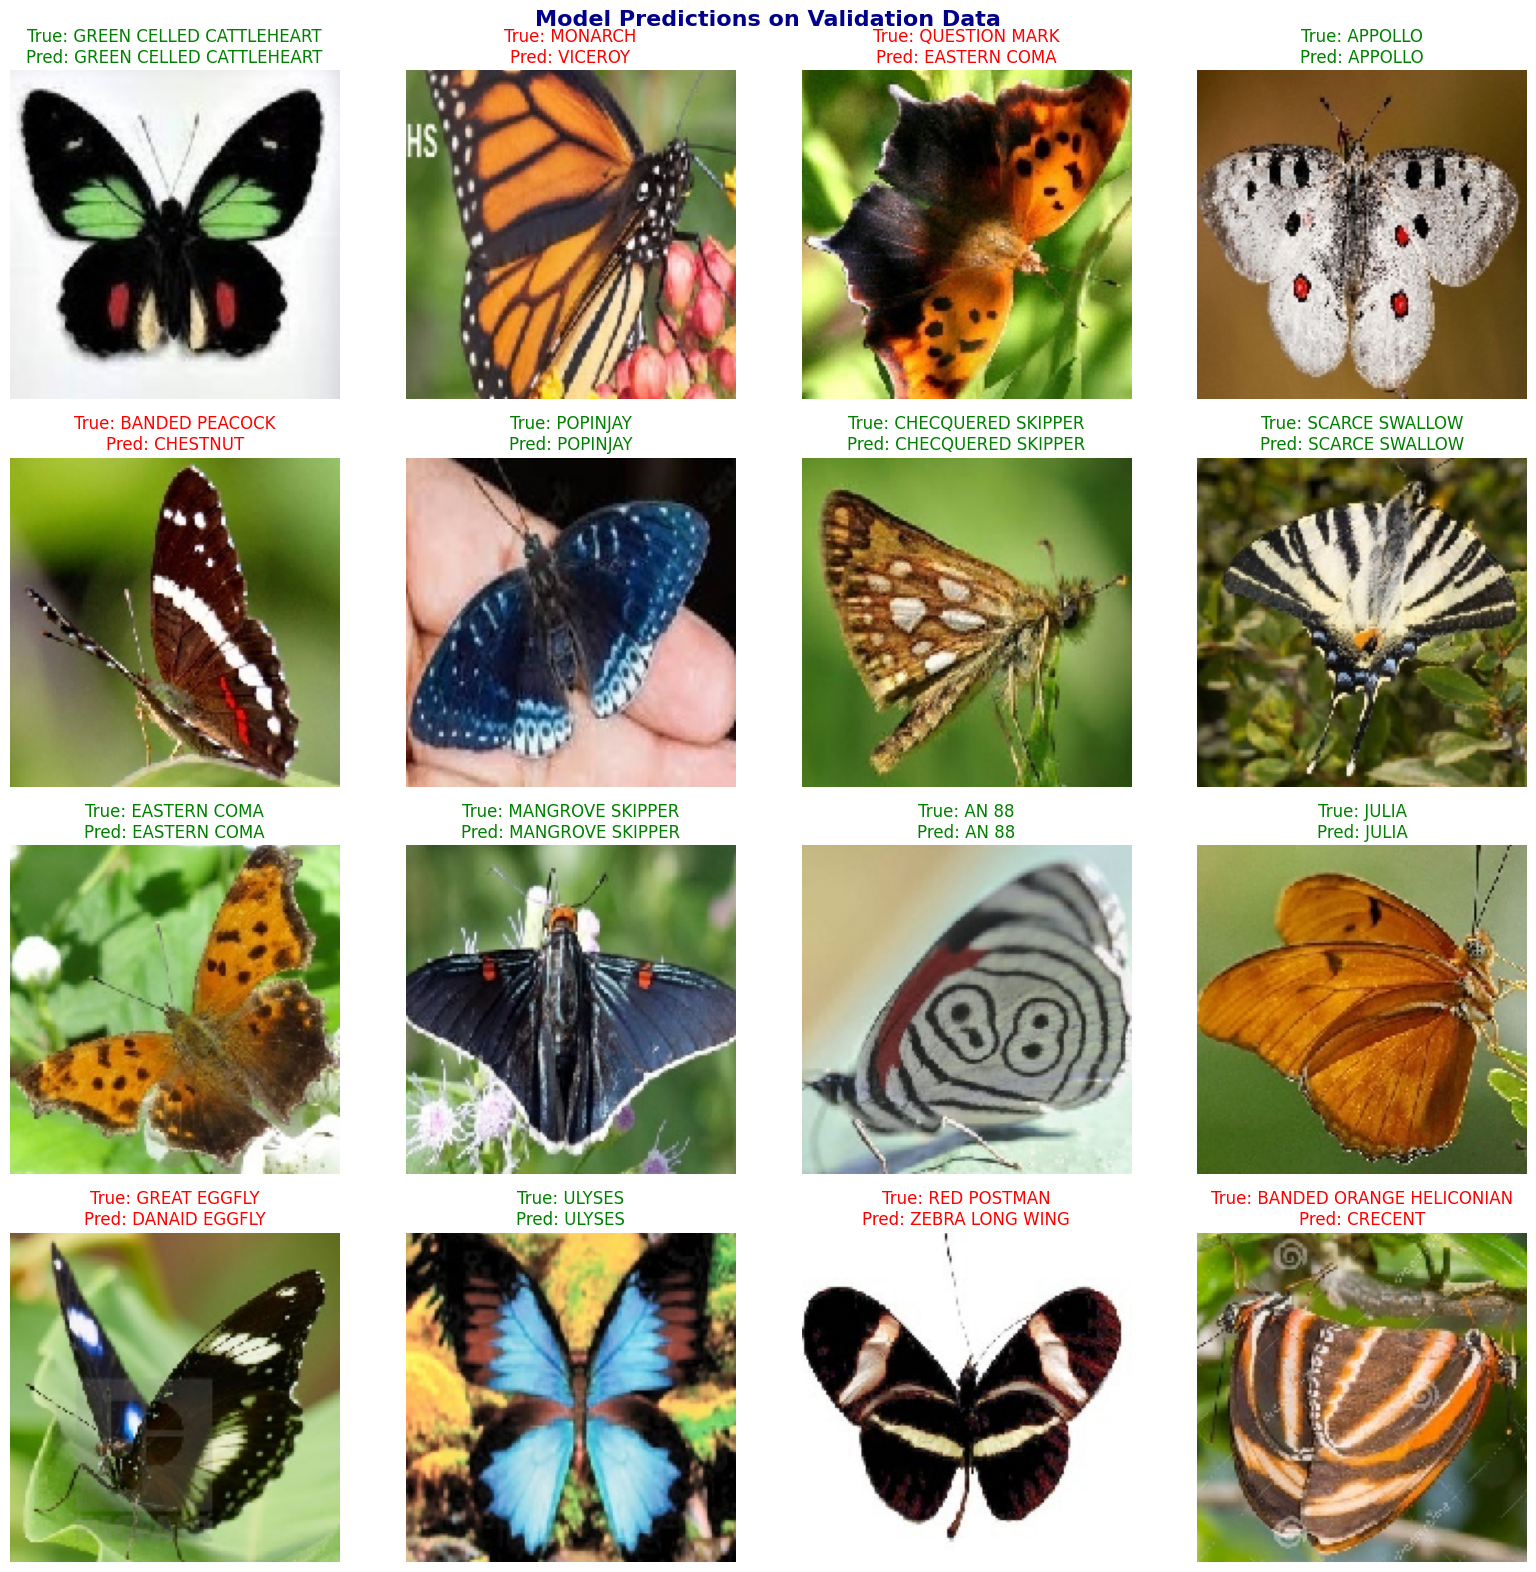

In [20]:
# Define the display_predictions function
def display_predictions(images, true_labels, pred_labels, class_names, num_images=16):
    num_images = min(num_images, len(images))
    cols = 4
    rows = (num_images // cols) + (num_images % cols > 0)
    plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(images[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        ax.axis("off")
    plt.suptitle("Model Predictions on Validation Data", fontsize=16, fontweight='bold', color='darkblue')
    plt.tight_layout()
    plt.show()

# Now call the function
display_predictions(val_images, true_labels, pred_labels, class_names, num_images=16)
